This notebook generates the processed data for dataset ds005, which is used in some of the chapter-specific notebooks from Poldrack, Mumford, and Nichols' _Handbook of fMRI Data Analysis (2nd Edition)_.  This also provides an example of using the nipype workflow mechanism.

In [15]:
import os, errno, sys,shutil

from fmrihandbook.utils.config import Config

config=Config()

%matplotlib inline

from nipype.interfaces import fsl, nipy, ants
import nibabel
from wand.image import Image as WImage
import numpy
import nilearn.plotting
import matplotlib.pyplot as plt
from nilearn.input_data import NiftiMasker
import fmrihandbook.utils
from fmrihandbook.utils.compute_fd_dvars import compute_fd,compute_dvars
import pickle
from fmrihandbook.utils.get_data import get_data

import nipype.interfaces.io as nio           # Data i/o
import nipype.pipeline.engine as pe          # pypeline engine
import nipype.algorithms.modelgen as model   # model specification
from nipype.interfaces.base import Bunch
import glob
import nipype.interfaces.utility as niu
from nipype.interfaces.c3 import C3dAffineTool
from nipype.interfaces.utility import Merge, IdentityInterface


rerun_analyses=False  # set to true to force rerun of everything



In [16]:
config.data=get_data('ds005')
print(config.data)

{'ds031': {'T2': '/Users/poldrack/data/fmri-handbook-2e-data/ds031/sub-01/ses-018/anat/sub-01_ses-018_run-001_T2w.nii.gz', 'func': '/Users/poldrack/data/fmri-handbook-2e-data/ds031/sub-01/ses-014/func/sub-01_ses-014_task-nback_run-001_bold.nii.gz', 'sbref': '/Users/poldrack/data/fmri-handbook-2e-data/ds031/sub-01/ses-014/func/sub-01_ses-014_task-nback_run-001_sbref.nii.gz', 'datadir': '/Users/poldrack/data/fmri-handbook-2e-data/ds031', 'fieldmap-phasediff': '/Users/poldrack/data/fmri-handbook-2e-data/ds031/sub-01/ses-014/fmap/sub-01_ses-014_phasediff.nii.gz', 'fieldmap-mag': '/Users/poldrack/data/fmri-handbook-2e-data/ds031/sub-01/ses-014/fmap/sub-01_ses-014_magnitude1.nii.gz', 'T1': '/Users/poldrack/data/fmri-handbook-2e-data/ds031/sub-01/ses-018/anat/sub-01_ses-018_run-001_T1w.nii.gz'}, 'ds005': {'datadir': '/Users/poldrack/data/fmri-handbook-2e-data/ds005'}}


## Structural workflow

In [17]:

subcodes=[os.path.basename(i) for i in glob.glob(os.path.join(config.data['ds005']['datadir'],'sub-*'))]
subcodes.sort()
#subcodes=subcodes[:1]
print(subcodes)

# Map field names to individual subject runs.
info = dict(func=[['subject_id','subject_id','runcode']],
            anat=[['subject_id', 'subject_id']])

infosource = pe.Node(interface=niu.IdentityInterface(fields=['subject_id']), name="infosource")

# this builds off of example at http://www.mit.edu/~satra/nipype-nightly/users/examples/fmri_ants_openfmri.html

infosource.iterables = ('subject_id', subcodes)

runinfo = pe.Node(interface=niu.IdentityInterface(fields=['runcode']), name="runinfo")

runinfo.iterables = ('runcode',['1','2','3'])


datasource_anat = pe.Node(interface=nio.DataGrabber(infields=['subject_id'],
                    outfields=['anat']),
                    name = 'datasource_anat')

datasource_anat.inputs.base_directory = config.data['ds005']['datadir']

datasource_anat.inputs.template = '%s/anat/%s_T1w.nii.gz'


datasource_anat.inputs.template_args = dict(anat=[['subject_id','subject_id']])

datasource_anat.inputs.sort_filelist = True

                     
datasource_func = pe.Node(interface=nio.DataGrabber(infields=['subject_id','runcode'],
                    outfields=['func']),
                    name = 'datasource_func')

datasource_func.inputs.base_directory = config.data['ds005']['datadir']

datasource_func.inputs.template = '%s/func/%s_task-mixedgamblestask_run-0%s_bold.nii.gz'

datasource_func.inputs.template_args = dict(func=[['subject_id','subject_id','runcode']])

datasource_func.inputs.sort_filelist = True

                                                 
preprocessing = pe.Workflow(name="preprocessing")

try:
    workdir='/Users/poldrack/data_unsynced/fmri-handbook-2e-data/ds005/nipype_workdir'
    assert os.path.exists(workdir)
except:
    workdir=os.path.join(config.data['ds005']['datadir'],'nipype_workdir')
    if not os.path.exists(workdir):
        os.mkdir(workdir)

preprocessing.base_dir = workdir

preprocessing.connect(infosource,'subject_id',datasource_anat,'subject_id')

preprocessing.connect(infosource,'subject_id',datasource_func,'subject_id')
preprocessing.connect(runinfo,'runcode',datasource_func,'runcode')



['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12', 'sub-13', 'sub-14', 'sub-15', 'sub-16']


### Bias field correction

In [18]:
bfc = pe.Node(interface=ants.N4BiasFieldCorrection(), name="bfc")
bfc.inputs.dimension = 3
bfc.inputs.save_bias = True

preprocessing.connect(datasource_anat, 'anat', bfc, 'input_image')

datasink = pe.Node(nio.DataSink(), name='datasink')
regex_subs = [('_combiner.*/sar', '/smooth/'),
              ('_combiner.*/ar', '/unsmooth/'),
              ('_aparc_ts.*/sar', '/smooth/'),
              ('_aparc_ts.*/ar', '/unsmooth/'),
              ('_getsubcortts.*/sar', '/smooth/'),
              ('_getsubcortts.*/ar', '/unsmooth/'),
              ('series/sar', 'series/smooth/'),
              ('series/ar', 'series/unsmooth/'),
              ('_inverse_transform./', ''),
              ]
# Save the relevant data into an output directory
datasink.inputs.base_directory = os.path.join(config.data['ds005']['datadir'],'derivatives')
if not os.path.exists(datasink.inputs.base_directory):
    os.mkdir(datasink.inputs.base_directory)

#datasink.inputs.substitutions = substitutions
#datasink.inputs.regexp_substitutions = regex_subs #(r'(/_.*(\d+/))', r'/run\2')
#datasink.inputs.container=os.path.join()

preprocessing.connect(bfc, 'bias_image', datasink, 'bfc.bias')
preprocessing.connect(bfc, 'output_image', datasink, 'bfc.output')


### Brain extraction using BET###

In [19]:
bet_struct=pe.Node(interface=fsl.BET(), name="bet_struct")
bet_struct.inputs.reduce_bias=True
bet_struct.inputs.frac=0.4

preprocessing.connect(bfc,'output_image',bet_struct,'in_file')
preprocessing.connect(bet_struct, 'out_file', datasink, 'bet.output')
preprocessing.connect(bet_struct, 'mask_file', datasink, 'bet.mask')



### Segmentation using FAST

Do this to obtain the white matter mask, which we need for BBR registration.

In [20]:
fast=pe.Node(interface=fsl.FAST(), name="fast")

preprocessing.connect(bet_struct,'out_file',fast,'in_files')
preprocessing.connect(fast, 'partial_volume_files', datasink, 'fast.pvefiles')
preprocessing.connect(fast, 'tissue_class_map', datasink, 'fast.seg')

binarize = pe.Node(fsl.ImageMaths(op_string='-nan -thr 0.5 -bin'),
                   name='binarize')
pickindex = lambda x, i: x[i]
preprocessing.connect(fast, ('partial_volume_files', pickindex, 2),
                 binarize, 'in_file')
preprocessing.connect(binarize, 'out_file', datasink, 'fast.wmseg')



### Spatial normalization using ANTs

In [21]:
antsreg=pe.Node(interface=ants.Registration(), name="antsreg")
antsreg.inputs.fixed_image = os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz')
antsreg.inputs.transforms = ['Translation', 'Rigid', 'Affine', 'SyN']
antsreg.inputs.transform_parameters = [(0.1,), (0.1,), (0.1,), (0.2, 3.0, 0.0)]
antsreg.inputs.number_of_iterations = ([[10, 10, 10]]*3 +
                [[1, 5, 3]])
antsreg.inputs.dimension = 3
antsreg.inputs.write_composite_transform = True
antsreg.inputs.metric = ['Mattes'] * 3 + [['Mattes', 'CC']]
antsreg.inputs.metric_weight = [1] * 3 + [[0.5, 0.5]]
antsreg.inputs.radius_or_number_of_bins = [32] * 3 + [[32, 4]]
antsreg.inputs.sampling_strategy = ['Regular'] * 3 + [[None, None]]
antsreg.inputs.sampling_percentage = [0.3] * 3 + [[None, None]]
antsreg.inputs.convergence_threshold = [1.e-8] * 3 + [-0.01]
antsreg.inputs.convergence_window_size = [20] * 3 + [5]
antsreg.inputs.smoothing_sigmas = [[4, 2, 1]] * 3 + [[1, 0.5, 0]]
antsreg.inputs.sigma_units = ['vox'] * 4
antsreg.inputs.shrink_factors = [[6, 4, 2]] + [[3, 2, 1]]*2 + [[4, 2, 1]]
antsreg.inputs.use_estimate_learning_rate_once = [True] * 4
antsreg.inputs.use_histogram_matching = [False] * 3 + [True]
antsreg.inputs.initial_moving_transform_com = True
antsreg.inputs.output_warped_image = True

preprocessing.connect(bet_struct,'out_file',antsreg,'moving_image')
preprocessing.connect(antsreg, 'warped_image', datasink, 'ants.warped_image')
preprocessing.connect(antsreg, 'composite_transform', datasink, 'ants.composite_transform')
preprocessing.connect(antsreg, 'inverse_composite_transform', datasink, 'ants.inverse_composite_transform')



## Functional preprocessing

### Motion correction using MCFLIRT

This will take a few minutes.

In [22]:
mcflirt=pe.Node(interface=fsl.MCFLIRT(), name="mcflirt")
mcflirt.inputs.save_plots=True
mcflirt.inputs.mean_vol=True

preprocessing.connect(datasource_func, 'func', mcflirt, 'in_file')

preprocessing.connect(mcflirt, 'out_file', datasink, 'mcflirt.out_file')
preprocessing.connect(mcflirt, 'par_file', datasink, 'mcflirt.par')
preprocessing.connect(mcflirt, 'mean_img', datasink, 'mcflirt.mean')




Make links for the mean functional image and the motion parameters.

## Brain extraction

Use FSL's BET to obtain the brain mask for the functional data

In [23]:
bet_func=pe.Node(interface=fsl.BET(), name="bet_func")

bet_func.inputs.functional=True
bet_func.inputs.mask=True

preprocessing.connect(mcflirt, 'out_file', bet_func, 'in_file')

preprocessing.connect(bet_func, 'out_file', datasink, 'betfunc.out_file')
preprocessing.connect(bet_func, 'mask_file', datasink, 'betfunc.mask_file')

meanbetfunc=pe.Node(interface=fsl.MeanImage(), name="meanbetfunc")
preprocessing.connect(bet_func,'out_file',meanbetfunc,'in_file')
preprocessing.connect(meanbetfunc, 'out_file', datasink, 'betfunc.mean_file')



#### BBR registration of functional to structural

In [24]:
mean2anat = pe.Node(fsl.FLIRT(), name='mean2anat')
mean2anat.inputs.dof = 6
preprocessing.connect(meanbetfunc, 'out_file', mean2anat, 'in_file')
preprocessing.connect(bet_struct, 'out_file', mean2anat, 'reference')

mean2anatbbr = pe.Node(fsl.FLIRT(), name='mean2anatbbr')
mean2anatbbr.inputs.dof = 6
mean2anatbbr.inputs.cost = 'bbr'
mean2anatbbr.inputs.schedule = os.path.join(os.getenv('FSLDIR'),
                                            'etc/flirtsch/bbr.sch')

preprocessing.connect(meanbetfunc, 'out_file', mean2anatbbr, 'in_file')
preprocessing.connect(binarize, 'out_file', mean2anatbbr, 'wm_seg')
preprocessing.connect(bet_struct, 'out_file', mean2anatbbr, 'reference')
preprocessing.connect(mean2anat, 'out_matrix_file',
                 mean2anatbbr, 'in_matrix_file')

preprocessing.connect(mean2anatbbr, 'out_matrix_file', datasink, 'bbr.out_matrix')
preprocessing.connect(mean2anatbbr, 'out_file', datasink, 'bbr.out_file')

# convert BBR matrix to ITK for ANTS

convert2itk = pe.Node(C3dAffineTool(),
                      name='convert2itk')
convert2itk.inputs.fsl2ras = True
convert2itk.inputs.itk_transform = True
preprocessing.connect(mean2anatbbr, 'out_matrix_file', convert2itk, 'transform_file')
preprocessing.connect(meanbetfunc, 'out_file', convert2itk, 'source_file')
preprocessing.connect(bet_struct, 'out_file', convert2itk, 'reference_file')

In [25]:
# Concatenate the affine and ants transforms into a list

pickfirst = lambda x: x[0]

merge = pe.Node(Merge(2), iterfield=['in2'], name='mergexfm')
preprocessing.connect(convert2itk, 'itk_transform', merge, 'in2')
preprocessing.connect(antsreg, 'composite_transform', merge, 'in1')

warpmean = pe.Node(ants.ApplyTransforms(), name='warpmean')
warpmean.inputs.input_image_type = 0
warpmean.inputs.interpolation = 'Linear'
warpmean.inputs.invert_transform_flags = [False, False]
warpmean.inputs.terminal_output = 'file'
warpmean.inputs.args = '--float'
warpmean.inputs.reference_image = os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz')

warpall = pe.MapNode(ants.ApplyTransforms(),
                     iterfield=['input_image'],
                     name='warpall')
warpall.inputs.input_image_type = 0
warpall.inputs.interpolation = 'Linear'
warpall.inputs.invert_transform_flags = [False, False]
warpall.inputs.terminal_output = 'file'
warpall.inputs.args = '--float'
warpall.inputs.num_threads = 2
warpall.plugin_args = {'sbatch_args': '--mem=6G -c 2'}
warpall.inputs.reference_image = os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz')


preprocessing.connect(meanbetfunc, 'out_file', warpmean, 'input_image')
preprocessing.connect(merge, 'out', warpmean, 'transforms')
preprocessing.connect(bet_func, 'out_file', warpall, 'input_image')
preprocessing.connect(merge, 'out', warpall, 'transforms')
preprocessing.connect(warpall,'output_image',datasink,'ants.warped_func')
preprocessing.connect(warpmean,'output_image',datasink,'ants.warped_mean')

graph=preprocessing.run() #plugin='MultiProc', plugin_args={'n_procs' : 2})

INFO:workflow:['check', 'execution', 'logging']
INFO:workflow:Running serially.
INFO:workflow:Executing node datasource_anat.a14 in dir: /Users/poldrack/data_unsynced/fmri-handbook-2e-data/ds005/nipype_workdir/preprocessing/_subject_id_sub-15/datasource_anat
INFO:workflow:Executing node datasource_func.a1.a02 in dir: /Users/poldrack/data_unsynced/fmri-handbook-2e-data/ds005/nipype_workdir/preprocessing/_runcode_2/_subject_id_sub-03/datasource_func
INFO:workflow:Executing node datasource_func.a0.a12 in dir: /Users/poldrack/data_unsynced/fmri-handbook-2e-data/ds005/nipype_workdir/preprocessing/_runcode_1/_subject_id_sub-13/datasource_func
INFO:workflow:Executing node datasource_func.a1.a00 in dir: /Users/poldrack/data_unsynced/fmri-handbook-2e-data/ds005/nipype_workdir/preprocessing/_runcode_2/_subject_id_sub-01/datasource_func
INFO:workflow:Executing node datasource_func.a0.a11 in dir: /Users/poldrack/data_unsynced/fmri-handbook-2e-data/ds005/nipype_workdir/preprocessing/_runcode_1/_sub

In [1]:
workdir

NameError: name 'workdir' is not defined

### Registration check
#### Show overlays of highres-template and functional-highres

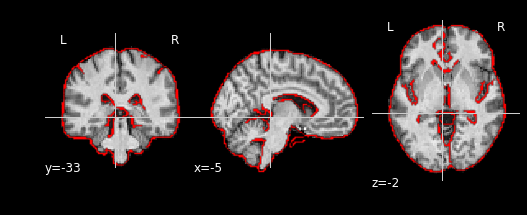

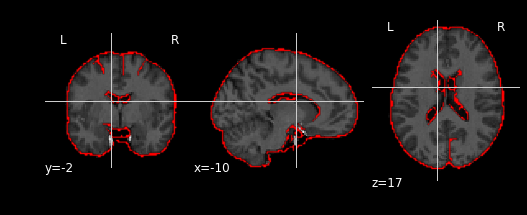

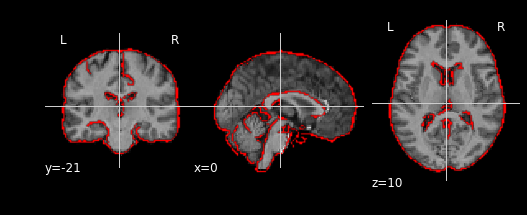

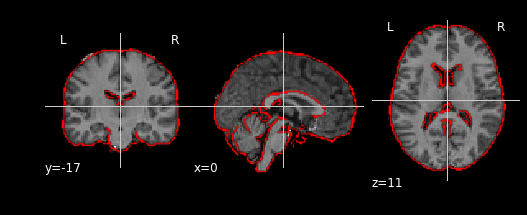

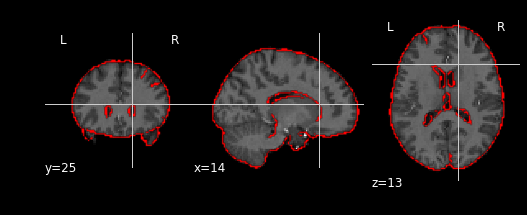

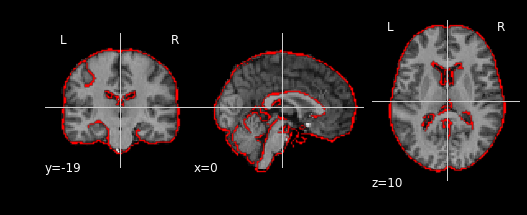

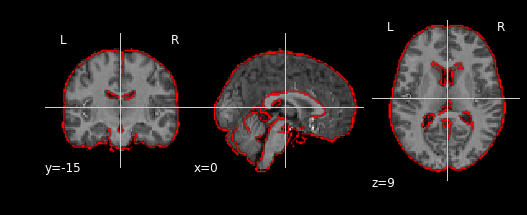

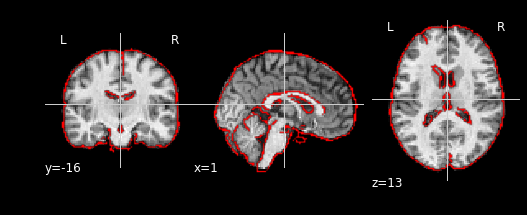

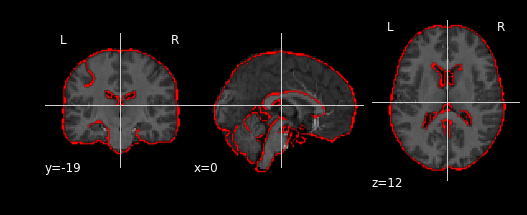

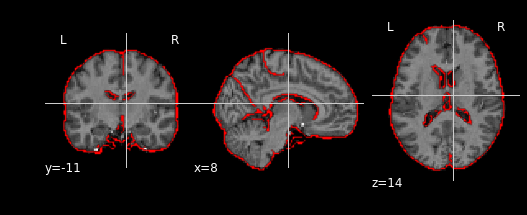

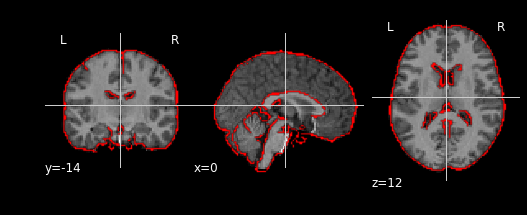

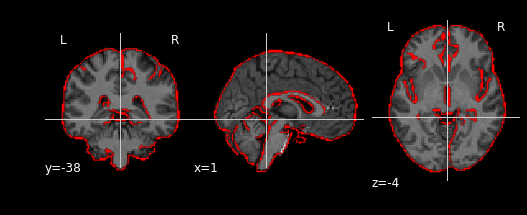

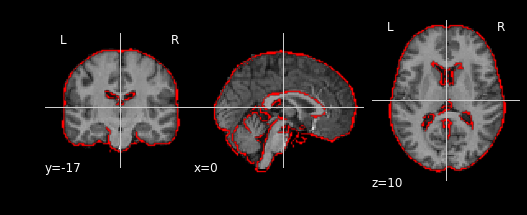

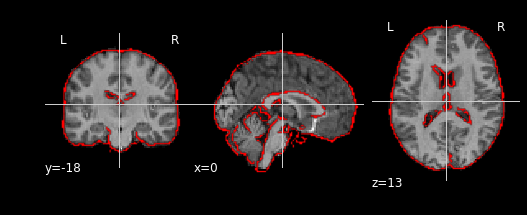

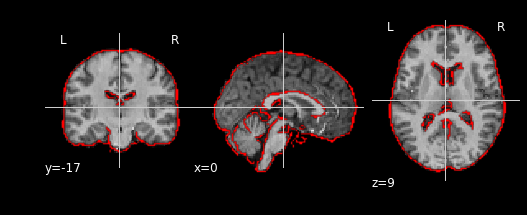

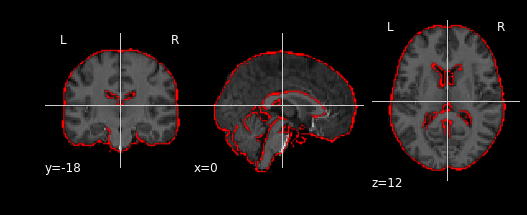

In [13]:
for subcode in subcodes:
    antsregfile=os.path.join(config.data['ds005']['datadir'],
                             'derivatives/ants/warped_image/_subject_id_%s/transform_Warped.nii.gz'%subcode)
    if os.path.exists(antsregfile):
        mask_display=nilearn.plotting.plot_epi(antsregfile,cmap='gray')
        mask_display.add_edges(os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'))

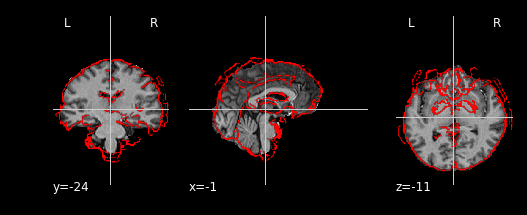

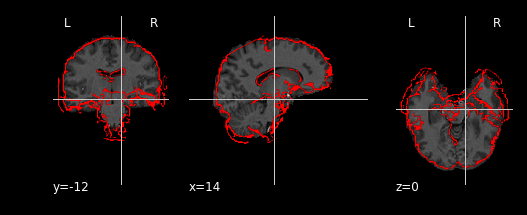

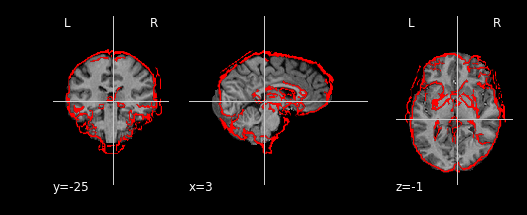

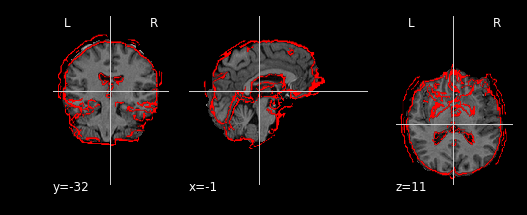

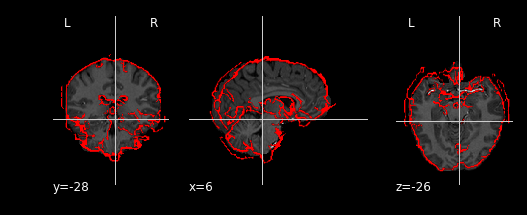

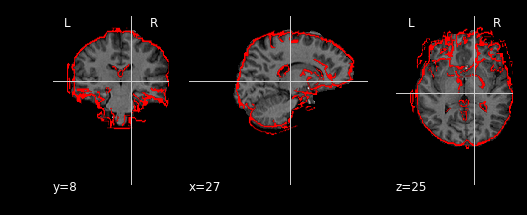

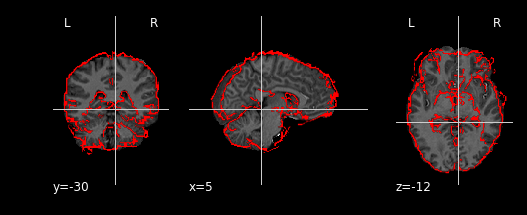

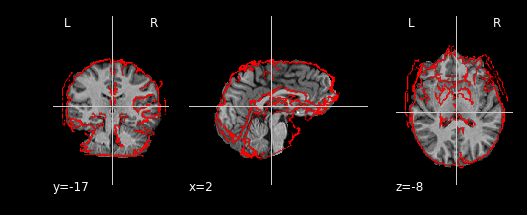

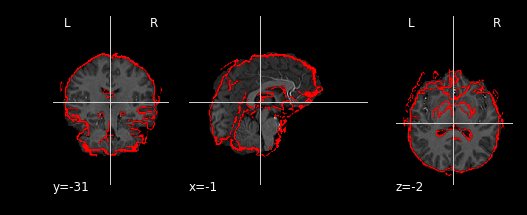

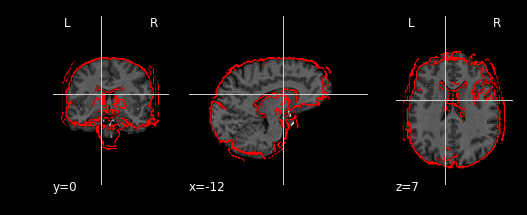

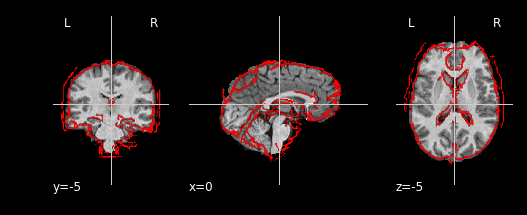

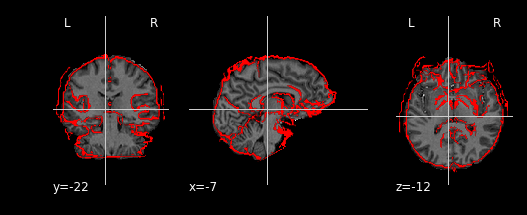

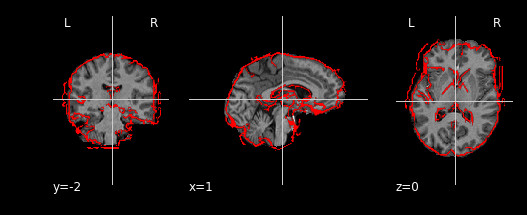

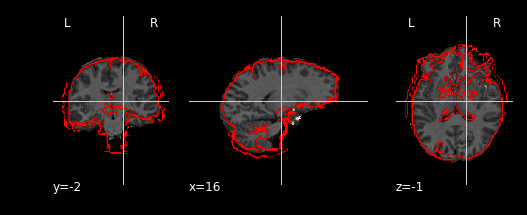

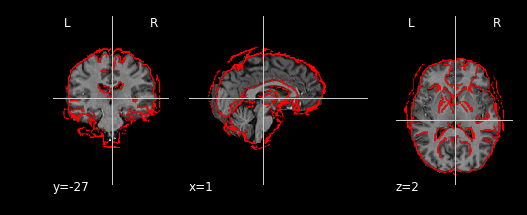

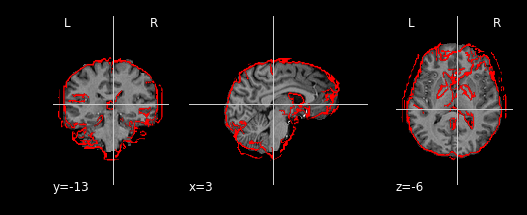

In [14]:
for subcode in subcodes:
    antsregfile=os.path.join(config.data['ds005']['datadir'],
                             'derivatives/bet/output/_subject_id_%s/%s_T1w_corrected_brain.nii.gz'%(subcode,subcode))
    if os.path.exists(antsregfile):
        mask_display=nilearn.plotting.plot_epi(antsregfile,cmap='gray')
        mask_display.add_edges(os.path.join(config.data['ds005']['datadir'],
            'derivatives/bbr/out_file/_runcode_1/_subject_id_%s/%s_task-mixedgamblestask_run-01_bold_mcf_brain_mean_flirt.nii.gz'%(subcode,subcode)))

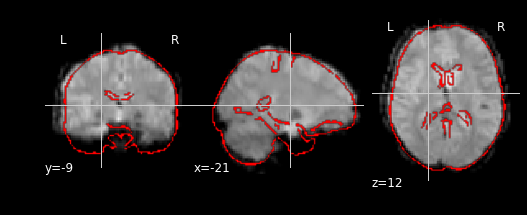

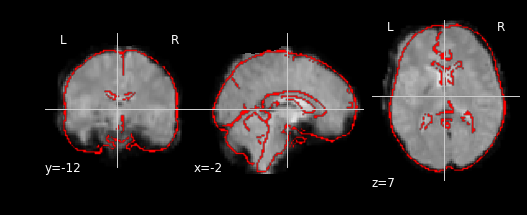

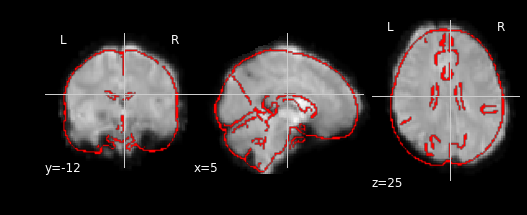

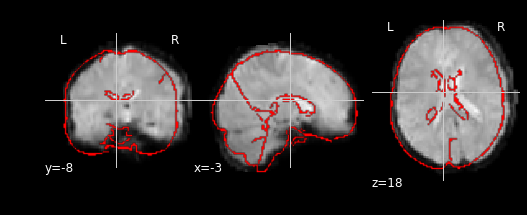

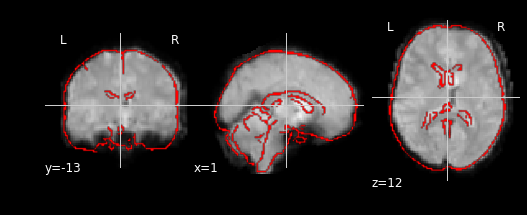

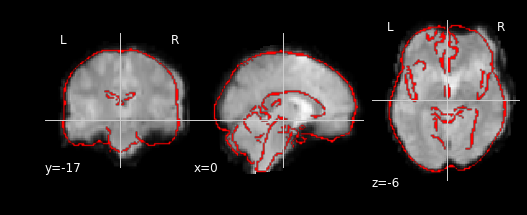

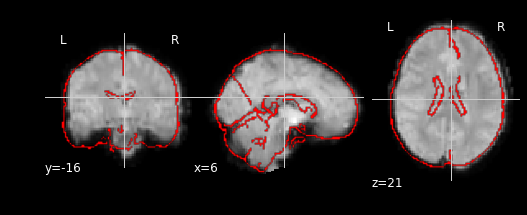

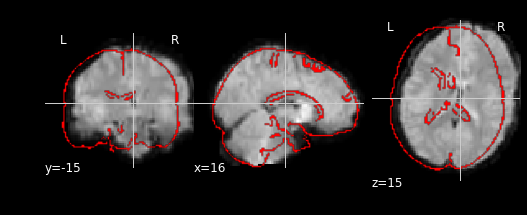

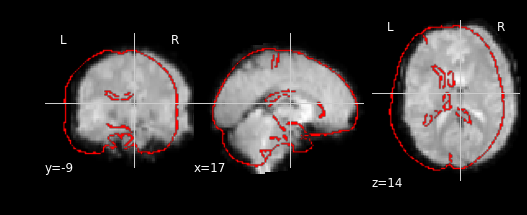

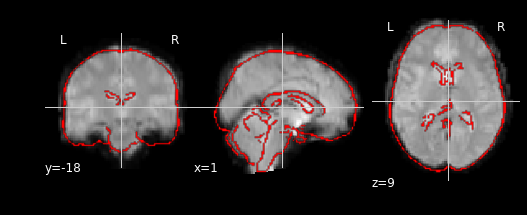

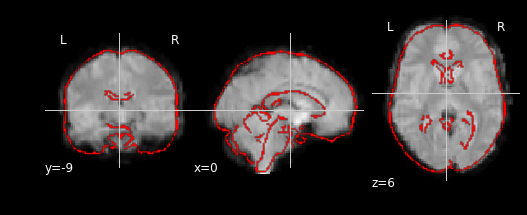

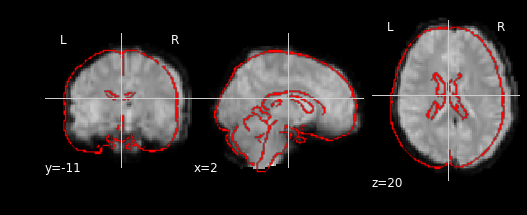

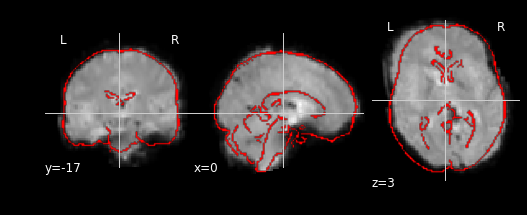

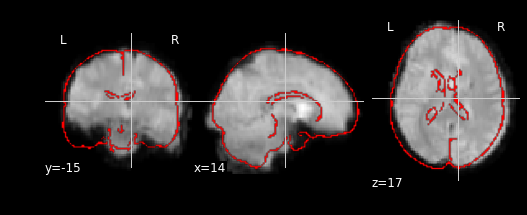

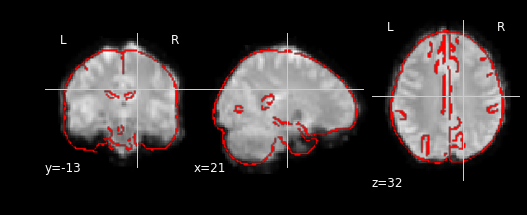

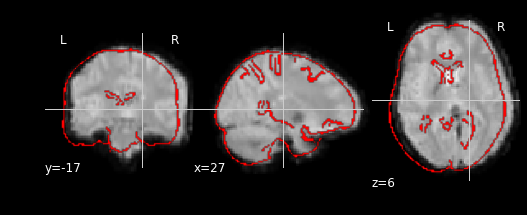

In [28]:
# warped functional to MNI
for subcode in subcodes:
    antsregfile=os.path.join(config.data['ds005']['datadir'],
       'derivatives/ants/warped_mean/_runcode_1/_subject_id_%s/%s_task-mixedgamblestask_run-01_bold_mcf_brain_mean_trans.nii.gz'%(subcode,subcode))
    if os.path.exists(antsregfile):
        mask_display=nilearn.plotting.plot_epi(antsregfile,cmap='gray')
        mask_display.add_edges(os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'))

### QA for fMRI data

Load motion data and compute FD/DVARS

In [41]:
fd={}
dvars={}
for subcode in subcodes:
    fd[subcode]={}
    for runcode in range(1,4):
        motfile=os.path.join(config.data['ds005']['datadir'],
            'derivatives/mcflirt/par/_runcode_%d/_subject_id_%s/%s_task-mixedgamblestask_run-%02d_bold_mcf.nii.gz.par'%(runcode,subcode,subcode,runcode))
        

        motiondata=numpy.loadtxt(motfile)
        fd=compute_fd(motiondata)
        meanfile=os.path.join(config.data['ds005']['datadir'],
            'derivatives/betfunc/out_file/_runcode_%d/_subject_id_%s/%s_task-mixedgamblestask_run-%02d_bold_mcf_brain.nii.gz'%(runcode,subcode,subcode,runcode))
        meandata=nibabel.load(meanfile)
        mask=nibabel.load(os.path.join(config.data['ds005']['datadir'],
            'derivatives/betfunc/mask_file/_runcode_%d/_subject_id_%s/%s_task-mixedgamblestask_run-%02d_bold_mcf_brain_mask.nii.gz'%(runcode,subcode,subcode,runcode)))
        masker=NiftiMasker(mask_img=mask)
        maskdata=masker.fit_transform(meandata)
        globalmean=numpy.mean(maskdata,0)
        dvars=compute_dvars(globalmean)
        outdir=os.path.dirname(motfile)
        numpy.savetxt(os.path.join(outdir,'fd.txt'),fd)
        numpy.savetxt(os.path.join(outdir,'dvars.txt'),dvars)

/Users/poldrack/anaconda/envs/py3k/lib/python3.5/site-packages/fmrihandbook-0.1.0-py3.5.egg/fmrihandbook/utils/compute_fd_dvars.py:38: RuntimeWarning: invalid value encountered in true_divide


In [40]:
# Plot motion data

NiftiMasker(detrend=False, high_pass=None, low_pass=None, mask_args=None,
      mask_img=<nibabel.nifti1.Nifti1Image object at 0x10e9c4390>,
      mask_strategy='background', memory=Memory(cachedir=None),
      memory_level=1, sample_mask=None, sessions=None, smoothing_fwhm=None,
      standardize=False, t_r=None, target_affine=None, target_shape=None,
      verbose=0)

## Spatial smoothing

Perform spatial smoothing using Gaussian kernel. Can you spot the difference between top and bottom rows?

In [ ]:
try:
    assert os.path.exists(config.data['func_mcf_smooth'])
    assert not rerun_analyses
except:
    smooth = mem.cache(fsl.utils.Smooth)
    smooth_results = smooth(fwhm=2.5,
                            in_file=config.data['func_mcf'],
                            output_type = "NIFTI")
    output_dir=os.path.dirname(config.data['func_mcf'])
    config.data['func_mcf_smooth']=os.path.join(output_dir,
                        os.path.basename(smooth_results.outputs.smoothed_file))
    shutil.copy(smooth_results.outputs.smoothed_file,config.data['func_mcf_smooth'])

nilearn.plotting.plot_epi(config.data['meanfunc'],
                              colorbar=True, vmin=410, vmax=21000)
nilearn.plotting.plot_epi(nilearn.image.mean_img(config.data['func_mcf_smooth']),
                              colorbar=True, vmin=410, vmax=21000)

## High pass filtering

High-pass filtering - this will take a few minutes

In [ ]:
try:
    assert os.path.exists(config.data['func_mcf_smooth_hpf_rescaled'])
    assert not rerun_analyses
except:

    hpfilt = mem.cache(fsl.maths.TemporalFilter)
    TR = 1.16
    hpfilt_results = hpfilt(highpass_sigma = 100/(2*TR),
                            in_file=config.data['func_mcf_smooth'],
                            output_type = "NIFTI")

    mean = mem.cache(fsl.maths.MeanImage)
    mean_results = mean(in_file = config.data['func_mcf_smooth'])

    rescale = mem.cache(fsl.maths.BinaryMaths)
    rescale_results = rescale(in_file=hpfilt_results.outputs.out_file,
                              operand_file = mean_results.outputs.out_file,
                              operation = "add",
                              output_type = "NIFTI")
    output_dir=os.path.dirname(config.data['func_mcf_smooth'])
    config.data['func_mcf_smooth_hpf_rescaled']=os.path.join(output_dir,
                                    os.path.basename(rescale_results.outputs.out_file))
    shutil.copy(rescale_results.outputs.out_file,config.data['func_mcf_smooth_hpf_rescaled'])
